In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
from time import sleep
from tqdm import tqdm

In [6]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 10
net = SumEncoder(set_channels,latent_dim,hidden_dim)

In [7]:
net

SumEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [8]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [9]:
#net = net.cuda()

In [10]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x, sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 9: 100%|█████| 1875/1875 [01:19<00:00, 23.51batch/s, acc=87.5, loss=0.466]


In [11]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1: 100%|███████| 312/312 [00:08<00:00, 37.85batch/s, acc=78.1, loss=0.594]


In [9]:
#torch.save(net.state_dict(),'model_sum_encoder.pth')

In [10]:
model = torch.load('./SumEncoder_model_mnist.pth' ,map_location=torch.device('cpu'))
miNet = SumEncoder(set_channels,latent_dim,hidden_dim)

In [11]:
miNet.load_state_dict(torch.load('./SumEncoder_model_mnist.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
miNet

SumEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [13]:
miNet = miNet
miNet.eval()
losses = []
accs = []
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0: 100%|███████████████████████████████| 312/312 [00:08<00:00, 36.21batch/s, acc=87.5, loss=0.3]

loss: 0.57, acc: 0.81


In [14]:
for name, param in miNet.named_parameters():
    print(name, param.size())

conv.0.weight torch.Size([32, 2, 1])
conv.0.bias torch.Size([32])
conv.2.weight torch.Size([32, 32, 1])
conv.2.bias torch.Size([32])
lin.0.weight torch.Size([32, 32])
lin.0.bias torch.Size([32])
lin.2.weight torch.Size([16, 32])
lin.2.bias torch.Size([16])
classifier.0.weight torch.Size([16, 16])
classifier.0.bias torch.Size([16])
classifier.2.weight torch.Size([10, 16])
classifier.2.bias torch.Size([10])


In [15]:
miNet

SumEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [16]:
model1 = MaxEncoder(set_channels,latent_dim,hidden_dim)
model1 = torch.nn.Sequential(*(list(miNet.children())[:-2]))
print(model1)

Sequential(
  (0): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
)


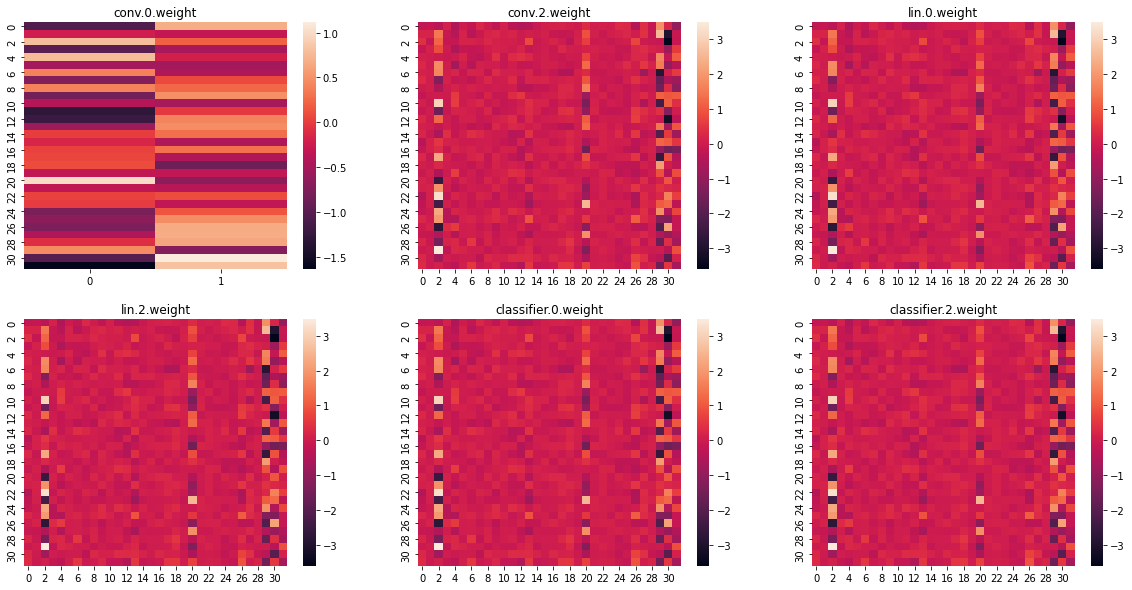

In [17]:
get_weight(miNet)

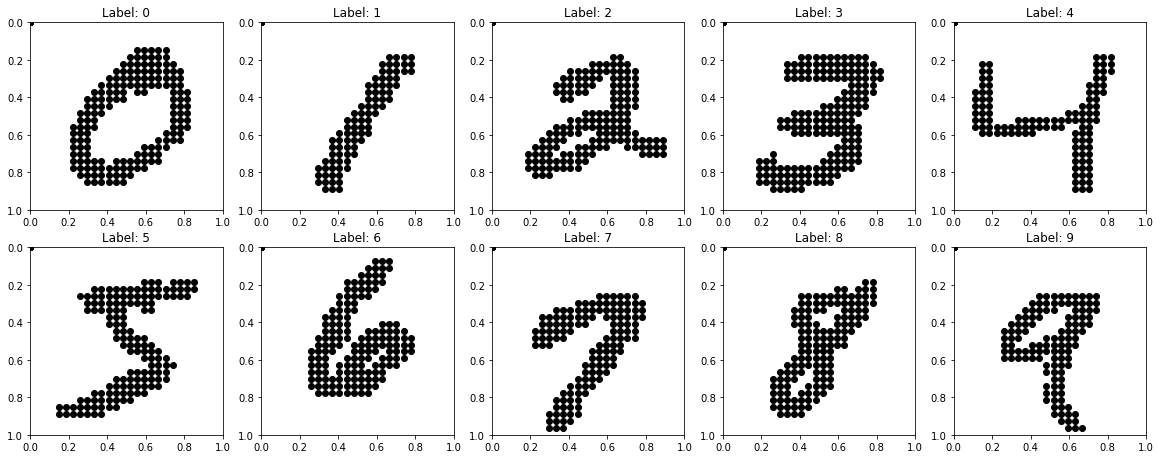

In [18]:
dataset_mnist_set = MNISTSet(full=True)
class_names =   [ 0 , 1 , 2,  3 , 4 , 5 , 6 , 7 ,  8 ,  9]
sampleSet = []
sampleMask = []
for i in range(len(class_names)):
    for j in range(len(dataset_mnist_set)):
        if i == dataset_mnist_set[j][0]:
            sampleSet.append(dataset_mnist_set[j][1])
            sampleMask.append(dataset_mnist_set[j][2])
            break
fig = plt.figure(figsize=(20, 20))

for i,set in enumerate(sampleSet):
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'k')
    plt.axis([0, 1, 1, 0])
    plt.title('Label: {}'.format(i))

In [19]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        pred = miNet(sampleSet[i].unsqueeze(0),sampleMask[i].unsqueeze(0))
        print("We obtained {}, and the expected is: {} with probaility".format(np.argmax(pred).item(),class_names[i]))

We obtained 0, and the expected is: 0 with probaility
We obtained 1, and the expected is: 1 with probaility
We obtained 2, and the expected is: 2 with probaility
We obtained 3, and the expected is: 3 with probaility
We obtained 4, and the expected is: 4 with probaility
We obtained 5, and the expected is: 5 with probaility
We obtained 6, and the expected is: 6 with probaility
We obtained 7, and the expected is: 7 with probaility
We obtained 8, and the expected is: 8 with probaility
We obtained 9, and the expected is: 9 with probaility


torch.Size([1, 32])


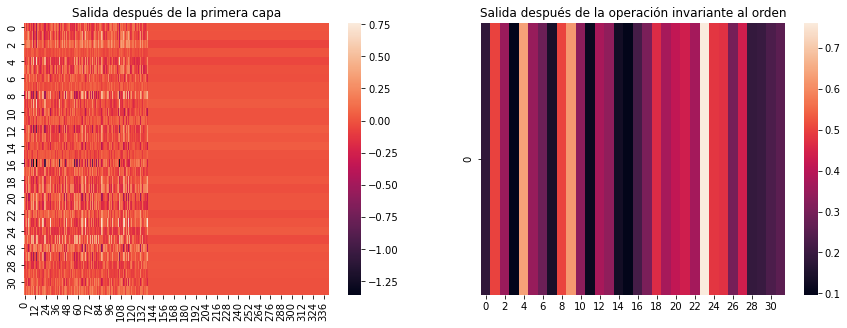

In [20]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.subplot(1,2,1) 
    pred = model1(sampleSet[8].unsqueeze(0))
    feature_map = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la primera capa")
    plt.subplot(1,2,2) 
    pred = pred.max(2)[0]
    max_map = pred
    print(max_map.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la operación invariante al orden")
    plt.show()

In [21]:

def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = abs(pred.squeeze(0))
    xsort,_ = torch.sort(features_map,descending=True)
    #print(xsort)
    xsortargs = torch.argsort(features_map,descending=True)
    #print(xsortargs[0][:][0])
    
    #xmax = features_map.max(axis=1)[0]
    #xmax,_ = torch.sort(xmax,descending=True)
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    xmaxargs,_ = torch.sort(xmaxargs,descending=True)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    xmin = features_map.min(axis=1)[0]
    #print(xmax.shape)
    xminargs = features_map.argmin(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxminargs = np.unique(xminargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    '''
        Vamos a probar cogiendo los 2 primeros maximos
    
    #print(features_map.shape)
    xsort,_ = torch.sort(features_map,descending=True)
    xsortargs= torch.argsort(features_map,descending=True)
    xsum = features_map.sum(1)
    print(xsortargs.shape)
    #print(xsortargs.shape)
    
    for i,tensor in enumerate(features_map):
        suma = 0
        z = 0
        #print(tensor.shape)
        while(suma<(xsum[i]*0.3) and z < 10):
            #print(xsortargs[z].shape)
            suma+= features_map[i][z]
            critical_points_y.append(points[0,xsortargs[i][z]])
            critical_points_x.append(points[1,xsortargs[i][z]])
            z += 1
            
    '''
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
    
    for k in range(len(newxminargs)):
        critical_points_y.append(points[0,newxminargs[k]])
        critical_points_x.append(points[1,newxminargs[k]])
    '''
    guardados = []
    for j in range(2):
        for i in range(32):
            if xsortargs[i][:][j] not in guardados:
                if j == 0 :
                    critical_points_y.append(points[0,xsortargs[i][:][j+10]])
                    critical_points_x.append(points[1,xsortargs[i][:][j+10]])
                    guardados.append(xsortargs[i][:][j+10])
                
                else:
                    
                    critical_points_y.append(points[0,xsortargs[i][:][j]])
                    critical_points_x.append(points[1,xsortargs[i][:][j]])
                    #print(xsort[i][:][j])
                    guardados.append(xsortargs[i][:][j])
                   

                    

            
    #print(len(critical_points_x))
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    s = np.stack((y,x))
    return s 

In [22]:
crit = dataset_mnist_set[800][1]
s = critical_points_MaxEncoder(model1,crit)
s.shape

(2, 33)

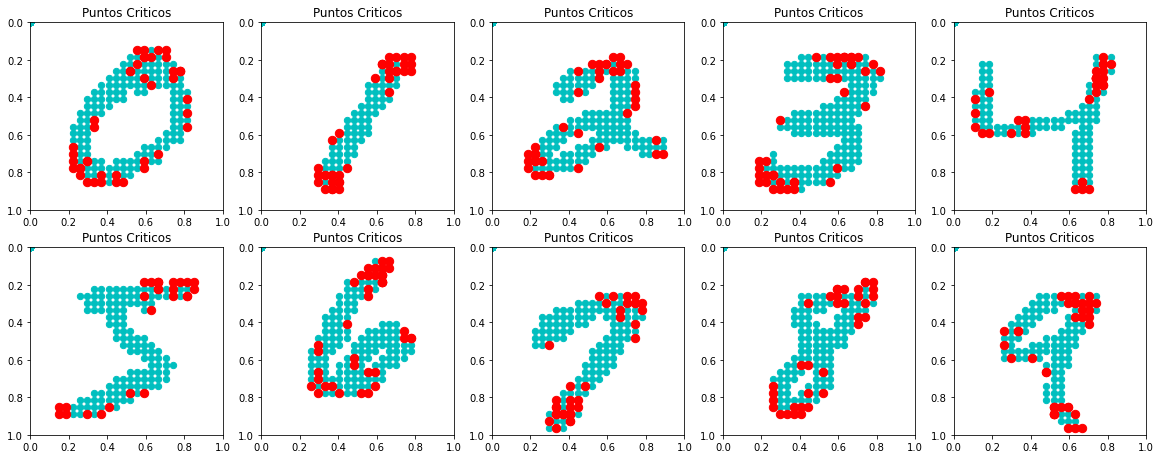

In [23]:
fig = plt.figure(figsize=(20, 20))
for i,set in enumerate(sampleSet):
    crit = critical_points_MaxEncoder(model1,set)
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'c',s=40)
    x = crit[1, :]
    y = crit[0, :]
    plt.scatter(x, y,marker='o',color = 'r',s=70)
    plt.axis([0, 1, 1, 0])
    plt.title('Puntos Criticos')
plt.show()

In [519]:
crit = dataset_mnist_set[88][1]
s = critical_points_MaxEncoder(model1,crit)
st = torch.Tensor(s).unsqueeze(0)
print(st.shape)
muestraSintetica = torch.zeros(1,2,0)
muestraSintetica = torch.cat((st,muestraSintetica,),2)
mask_sintetica = torch.ones(1,st.size(2))
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 2, 41])
torch.Size([1, 2, 41])
torch.Size([1, 41])


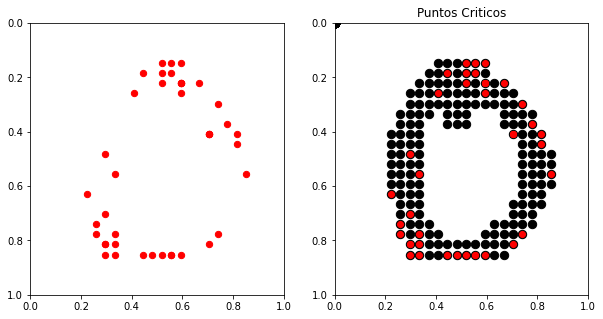

In [520]:
sam = muestraSintetica.squeeze(0)
#print(sam)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2,1)
x1 = s[1, :]
y1 = s[0, :]
plt.scatter(x1, y1,c ='r',s=40)
#plt.scatter(x1, y1,marker='x',color ='r')
plt.axis([0, 1, 1, 0])
ax = fig.add_subplot(1, 2,2)
x = crit[1, :]
y = crit[0, :]
plt.scatter(x, y,marker='o',color = 'k',s=70)
plt.axis([0, 1, 1, 0])
plt.title('Puntos Criticos')
plt.scatter(x1, y1,marker='o',color ='r')
plt.show()

In [521]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),0))
    predReal= miNet(crit.unsqueeze(0),dataset_mnist_set[98][1])
    print(pred)
    print(predReal)

torch.Size([1, 2, 41])
torch.Size([1, 41])
We obtained 2, and the expected is: 0
tensor([[-0.1885, -4.4644,  1.9870,  0.2007, -6.8478, -1.3124, -2.3767, -4.4529,
         -0.4654, -5.2817]])
tensor([[  5.5092,  -9.4385,  -2.3389,  -3.3350, -10.9366,  -2.3762,  -7.7201,
          -3.4707,  -0.8367,  -4.8113]])


In [522]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        #Preparacion de la muestra sintetica
        crit = sampleSet[i]
        s = critical_points_MaxEncoder(model1,crit)
        st = torch.Tensor(s).unsqueeze(0)
        muestraSintetica = torch.zeros(1,2,0)
        muestraSintetica = torch.cat((st,muestraSintetica,),2)
        mask_sintetica = torch.ones(1,st.size(2))
        #Prediccion de la red con la muestra
        pred = miNet(muestraSintetica,mask_sintetica)
        predReal= miNet(crit.unsqueeze(0),sampleMask[i].unsqueeze(0))
        print()
        print("We obtained {}, and the expected is: {}, with this trust {}, vs the real one: {}".format(np.argmax(pred).item(), class_names[i],round(pred.max().item(),2),round(predReal.max().item(),2)))
        


We obtained 2, and the expected is: 0, with this trust 2.71, vs the real one: 5.07

We obtained 2, and the expected is: 1, with this trust 2.29, vs the real one: 2.8

We obtained 2, and the expected is: 2, with this trust 1.68, vs the real one: 1.34

We obtained 3, and the expected is: 3, with this trust 2.65, vs the real one: 3.91

We obtained 0, and the expected is: 4, with this trust 0.66, vs the real one: -0.91

We obtained 3, and the expected is: 5, with this trust 1.31, vs the real one: 4.59

We obtained 2, and the expected is: 6, with this trust 3.81, vs the real one: 5.08

We obtained 2, and the expected is: 7, with this trust 1.26, vs the real one: 3.87

We obtained 2, and the expected is: 8, with this trust 2.15, vs the real one: 0.97

We obtained 2, and the expected is: 9, with this trust 1.21, vs the real one: 3.32


In [33]:
muestraSintetica = torch.zeros(1,2,262)
a  = torch.Tensor(x1).unsqueeze(0)
k  = torch.Tensor(y1).unsqueeze(0)
print(k.shape)
f = torch.cat((k,a),0).unsqueeze(0)
print(f.shape)
muestraSintetica = torch.cat((f,muestraSintetica,),2)
muestraSintetica.shape
mask_sintetica = torch.ones(1,342)
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 32])
torch.Size([1, 2, 32])
torch.Size([1, 2, 294])
torch.Size([1, 342])


In [34]:
342-32

310

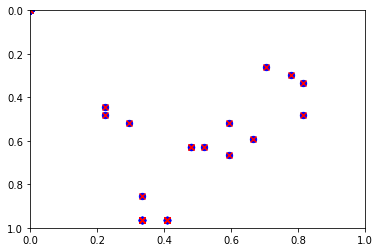

In [35]:
sam = muestraSintetica.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=40)
x1 = critical_points_x
y1 = critical_points_y
pyplot.scatter(x1, y1,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [36]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

torch.Size([1, 2, 294])
torch.Size([1, 342])
We obtained 3, and the expected is: 9


## Comprobación de que funciona a la inversa, con los puntos menos informativos

In [37]:
sorted_noncritical = -np.sort(-critical)[::-1]
sorted_noncritical_args = -np.argsort(-critical)[::-1]
print(sorted_noncritical)
#print(sorted_critical_args)
K = 100
noncritical_points_x = []
noncritical_points_y = []
for k in range(K):
    noncritical_points_x.append(points[0,sorted_noncritical_args[k]])
    noncritical_points_y.append(points[1,sorted_noncritical_args[k]])

#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(noncritical_points_x))
#print(critical_points_y)
print(np.sum(sorted_critical ==0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

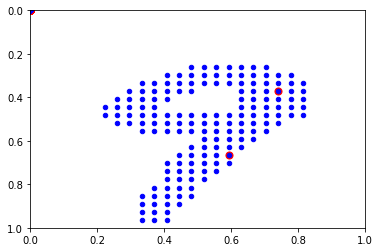

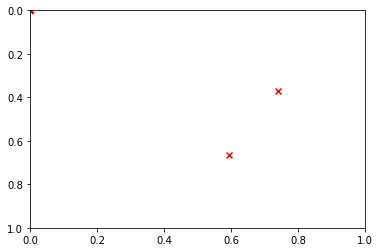

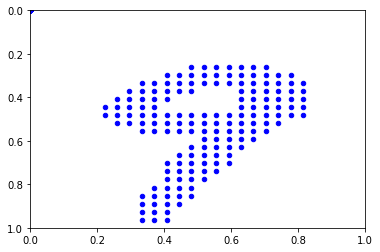

In [38]:
y1 = noncritical_points_x
x1 = noncritical_points_y
pyplot.scatter(x1, y1,marker='o',color ='r',s=50)
sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
pyplot.show()

y = noncritical_points_x
x = noncritical_points_y
pyplot.scatter(x, y,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()